# Setup

In [2]:
import os, subprocess
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm import trange
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF_F
from torchvision.utils import make_grid

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d.axes3d import Axes3D, art3d
from matplotlib.patches import Circle

# stable outputs across different runs
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# get device to calculate on (either CPU or GPU with minimum memory load)
def get_gpu_memory_map():
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    
    return gpu_memory_map

def get_device():
    if torch.cuda.is_available():
        memory_map = get_gpu_memory_map()
        device = "cuda:%d" % min(memory_map, key=memory_map.get)
    else:
        device = "cpu"
    
    print("Device:", device)
    return device

## Part 1: The CIFAR10 Dataset

For our implementation of an autoencoder we use the CIFAR10 Dataset.

In [4]:
# Here I defined a FloatTransformer class which in
# __call__ method takes a matrix tensor as an input 
# and return a torch float tensor

class FloatTransformer(object):
    def __call__(self, tensor):
        return tensor.type(torch.FloatTensor)

    
## load CIFAR10 dataset
root = '/home'
if not os.path.exists(root):
    os.mkdir(root)
# here I set the size of train and test dataset
batch_size = 128
train_size = 8192
test_size = 1024
    
# here we need to normalize images for the the relavent function

trans = transforms.Compose([transforms.ToTensor(),
                            FloatTransformer(), #[0,255]->[0,1]
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   #(R-0.5)/0.5 ,(G-0.5)/0.5 ,(B-0.5)/0.5  #pyTorch Document example [0,1]->[-1,1]
                            #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261) #https://github.com/kuangliu/pytorch-cifar/issues/19   [0,1]->[-2,2]
target_transform = None 

# get training dataset and extract a random subset of 8192 images for training
dataset_train = dset.CIFAR10(root=root, train=True, transform=trans, target_transform=target_transform, download=True)
dataset_train, _ = torch.utils.data.random_split(dataset_train, [train_size, len(dataset_train)-train_size])

# get test dataset and extract a random subset of 1024 images for testing
dataset_test = dset.CIFAR10(root=root, train=False, transform=trans, target_transform=target_transform, download=True)
dataset_test, _ = torch.utils.data.random_split(dataset_test, [test_size, len(dataset_test)-test_size])

#These are the classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# the dataloader load the images(datasets)
# then with the size of the batch_size which
# I set above make them split and then shuffle as well

dataloader_train = torch.utils.data.DataLoader(
                 dataset=dataset_train,
                 batch_size=batch_size,
                 shuffle=True)

# The dataloader here do the same 
#operation from above for test dataset 

dataloader_test = torch.utils.data.DataLoader(
                dataset=dataset_test,
                batch_size=batch_size,
                shuffle=False)

#Here I displyed the size of the train & test images

print("Train images: {} Batches: {}".format(len(dataset_train), len(dataloader_train)))
print("Test images: {} Batches: {}".format(len(dataset_test), len(dataloader_test)))


Extracting /home/cifar-10-python.tar.gz to /home
Files already downloaded and verified
Train images: 8192 Batches: 64
Test images: 1024 Batches: 8


 deer   car   cat   car  frog  ship   cat horse


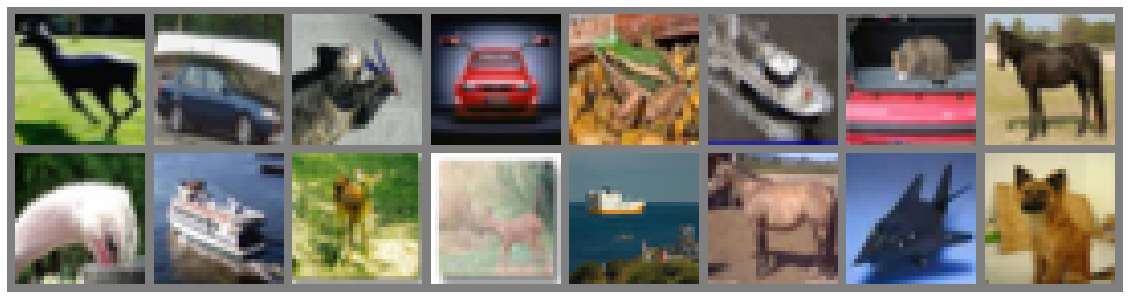

 bird  ship  deer  deer  ship horse plane   dog


In [5]:
# In this section I try to show some random images
def imshow(img):
    plt.figure(figsize=(20,10))
    img=img/2+0.5 #[-1,1]-->[0,1]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
# get some random training images
dataiter = iter(dataloader_train)
images, labels = dataiter.next()

# show images
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))
imshow(make_grid(images[:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(8,16)))

## Part 2: Autoencoder and embedding

**Part 2.1** CNN with an encoder and decoder 


*Encoder Structure*:

|Layer | Type | Maps | Size | Kernel | Stride | Pad. | Activ. |
| ---  | ---  | ---  | ---  | ---    | ---    | ---  | ---    |
|In | Input | 3 | 32$\times$32 | -  | - |- |  - |
|C1 | Conv. | 12 | 16$\times$16 | 4$\times$4  | 2 | 1 |  relu |
|C2 | Conv. | 24 | 8$\times$8 | 4$\times$4  | 2 | 1 | relu |
|C3 | Conv. | 48 | 4$\times$4 | 4$\times$4  | 2 | 1 | relu | 

*Decoder Structure*: 

|Layer | Type | Maps | Size | Kernel | Stride | Pad. | Activ. |
| ---  | ---  | ---  | ---  | ---    | ---    | ---  | ---    |
|In | Input       | 48 | 4$\times$4 | -  | - |- |  - |
|C1 | Trans.Conv. | 24 | 8$\times$8 | 4$\times$4  | 2 | 1 |  relu|
|C2 | Trans.Conv. | 12 | 16$\times$16 | 4$\times$4  | 2 | 1 |  relu|
|C3 | Trans.Conv. | 3 | 32$\times$32 | 4$\times$4 | 2 | 1 | tanh | 
    
    
    


From above structure we can see the encoder & decoder has 3 layers 
the activation for Decoder is tanh because we normalized between (1&-1)

In [6]:
# Here We defined three convolutional layers for authoencoder
# each cnn layer contains: "conv2","BatchNorm2d" and  Relu activation function
n_layers='3_layer'
# implement autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(3, 12, kernel_size=4, stride=2, padding=1), #3x32x32 to 12x16x16
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1), #12x16x16 to 24x8x8
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 48, kernel_size=4, stride=2, padding=1), #24x8x8 to 48x4x4
            nn.BatchNorm2d(48),
            nn.ReLU(),
            #nn.Conv2d(48, 96, kernel_size=4, stride=2, padding=1), #48x4x4 to 96x2x2
            #nn.BatchNorm2d(96),
            #nn.ReLU(),
            #nn.Conv2d(96, 192, kernel_size=4, stride=2, padding=1), #96x2x2 to 192x1x1
            #nn.BatchNorm2d(192),
            #nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            #nn.ConvTranspose2d(192, 96, kernel_size=4, stride=2, padding=1, output_padding=0), #192x1x1 to 96x2x2
            #nn.BatchNorm2d(96),
            #nn.ReLU(),
            #nn.ConvTranspose2d(96, 48, kernel_size=4, stride=2, padding=1, output_padding=0), #96x2x2 to 48x4x4
            #nn.BatchNorm2d(48),
            #nn.ReLU(),
            nn.ConvTranspose2d(48, 24, kernel_size=4, stride=2, padding=1, output_padding=0), #48x4x4 to 24x8x8
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, kernel_size=4, stride=2, padding=1, output_padding=0), #24x8x8 to 12x16x16
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, kernel_size=4, stride=2, padding=1, output_padding=0), #12x16x16 to 3x32x32
            nn.BatchNorm2d(3),
            nn.Tanh()
        )
  # defined the forward function to take input
  # call the encoder to encod the input
  # call the decoder function to decode the encoded inpu
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    #with an pooling on output of trained encoder we have an embeding vector for each image 
    #this vector can used for MLP or other method for prediction
    def embedding(self,x):
        encoded = self.encoder(x)
        encoded = nn.AvgPool2d(2,2)(encoded) #48*4*4-->48x2x2 embedded features 
        encoded = encoded.view(encoded.size(0), -1)   #flatten 48x2x2->192
        return encoded
    

In [7]:
#First we set GPu usage 
#Then make a model
device = get_device()
temp_model = Autoencoder().to(device)
print("########Autoencoder########")
print("encoder:")
print(temp_model.encoder)
print("decoder:")
print(temp_model.decoder)

Device: cuda:0
########Autoencoder########
encoder:
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
)
decoder:
Sequential(
  (0): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): ConvTranspose2d(12,

 
I can explain our autoencoder works as follows:
The Autoencoder model takes a CIFAR10 image which is 32X32 pixcels and 3 chanel in RGB.

The encoder section with three convolutional layers converted the input image to the 4X4 matrix in depth 48.

The decoder section operate inversely of the encoder cnn layer.In fact we reconstruct the original image.

In addition,we have the embedinig function that transform the output of encoder layers to flatten vector.The output size is 192.


**Part 2.2** input & output size checking

In [8]:
#test model input output size
# here we can see we passed 128 images
# with size of 32X32  --> encode to 4X 4 then  decode --> 32X 32
for input_imgs, _ in dataloader_train:
        input_imgs= input_imgs.to(device)
        encoded, decoded = temp_model.forward(input_imgs)
        print(f'{input_imgs.shape}--->{encoded.shape}-->{decoded.shape}')
        print('embedding to:',temp_model.embedding(input_imgs).shape)
        break

torch.Size([128, 3, 32, 32])--->torch.Size([128, 48, 4, 4])-->torch.Size([128, 3, 32, 32])
embedding to: torch.Size([128, 192])


**Part 2.3** I train the model for around 500 epochs with an Adam learning algorithm .I evaluate the loss on the whole training and testset in each epoch. Even though I am using a tanh output it is a regression problem. The target output is now the input image. Therefore the loss has to compare to the input image and the predicted image.

I tried out some different optimizers ,learning rates and different number of convolutional layers.I observed optimizer and depth of net has a significant impact on the training. In the 6 layear (3_encoder and 3_decoder) the adam optimizer achieved the best result.

In [9]:
model=Autoencoder().to(device)
# implement autoencoder training
epochs = 500
# Define an optimizer and criterion
lr = 0.001
opt='adam'
criterion =nn.MSELoss()
if opt=='adam':
    optimizer = optim.Adam(model.parameters(),lr)
elif opt=='sgd':
    optimizer = optim.SGD(model.parameters(),lr,weight_decay=1e-5)

desc = "Train loss: %.4f - Test loss: %.4f"
pbar = trange(epochs, desc=desc % (0., 0.))
history={'train loss':[],'test loss':[]}
# iterate over epochs
for epoch in pbar:
    #training state
    train_loss=0
    model.train() #set model in train mode
    for inputs, _ in dataloader_train:
        inputs = inputs.to(device)#, target.to(device)
        #=====forward=====#
        _, outputs = model(inputs) # forward pass: compute predicted outputs by passing inputs to the model
        #=====calculate loss=====#
        loss = criterion(outputs, inputs) # calculate the loss
        train_loss += loss.item()*inputs.size(0) # update running training loss 
        #=====backward=====#
        optimizer.zero_grad() # clear the gradients of all optimized variables
        loss.backward()  # backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step() # perform a single optimization step (parameter update)
    train_loss = train_loss/len(dataloader_train.dataset) # calculate average loss over an epoch
    history['train loss'].append(train_loss)
    
    # testing state after each epoch
    test_loss = 0.0
    model.eval()#set model in validation mode
    for inputs, _ in dataloader_test:
        inputs = inputs.to(device)
        with torch.no_grad():
            _, outputs = model(inputs)
            loss = criterion(outputs, inputs) # calculate the loss
            test_loss += loss.item()*inputs.size(0) # update test loss      
    test_loss = test_loss/len(dataloader_test.dataset) # calculate average loss over an epoch
    history['test loss'].append(test_loss)
    
    pbar.set_description(desc % (train_loss,test_loss))
    # I set update to one 
    pbar.update(1)

#save weights  
print('Finished Training')
print('Saving Model...')
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(model.state_dict(), f"./weights/{n_layers}_autoencoder_{opt}_{lr}.pkl")
print('Model Saved!')

Train loss: 0.0055 - Test loss: 0.0049: 100%|██████████| 500/500 [15:05<00:00,  1.81s/it]

Finished Training
Saving Model...
Model Saved!


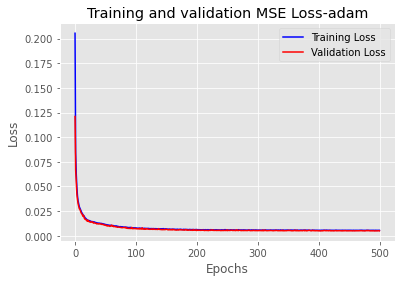

In [10]:
%matplotlib inline
plt.style.use("ggplot")
plt.figure()
plt.plot(history['train loss'], 'b', label='Training Loss')
plt.plot(history['test loss'],'r', label='Validation Loss')
plt.title(f'Training and validation MSE Loss-{opt}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
if not os.path.exists('./Result'):
    os.mkdir('./Result')
plt.savefig(f'Result/{n_layers}_MSE_{opt}_lr{lr}.png')
plt.show()

**Part 2.4:** I took 5 images from the data. For each image has been predicted a reconstructed image and display both.

orginal result


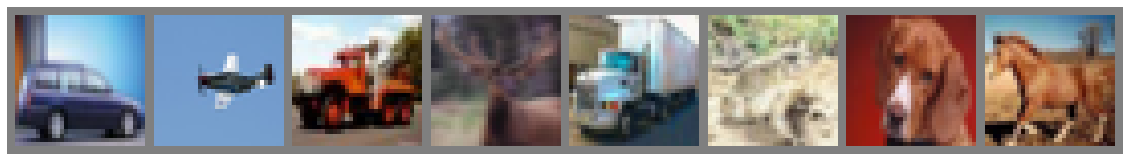

model result


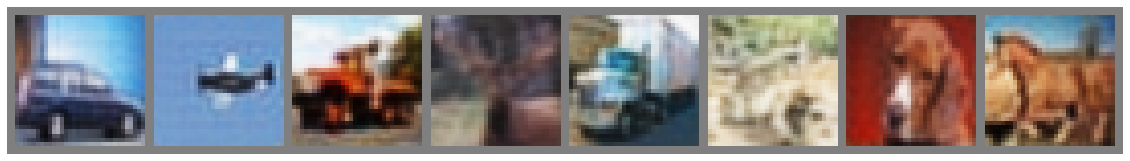

In [16]:
def torch_imshow(img):
    #img=img.permute(2,0, 1)
    img=img.transpose(0, 1)
    img=img.transpose(1, 2)
    img=img/2+0.5 #from [-1,1] to [0,1]
    plt.figure(figsize=(20,10))
    try:
        plt.imshow(img.cpu())
    except:
        plt.imshow(img.cpu().detach().numpy()) 
    plt.axis('off')
    plt.show()
# get some random training images
dataiter = iter(dataloader_train)
images, labels = dataiter.next()
# show images
print('orginal result')
imshow(make_grid(images[:8]))
model.eval()
_, outputs = model(images.to(device))
vectors=model.embedding(images.to(device))
outputs=outputs
print('model result')
torch_imshow(make_grid(outputs[:8]))

I can observe the similarity between the input and the out put of our model.

**Part 2.5:** Now we check output vectors with Knn method : 

https://discuss.pytorch.org/t/k-nearest-neighbor-in-pytorch/59695

https://discuss.pytorch.org/t/is-there-a-way-to-calculate-cosine-similarity-between-all-combinations-of-embeddings/19446/5

embedded vector:
[1.4 1.4 0.9 1.3 1.1 1.  0.6 1.1 1.  1.3 1.  1.2 0.  0.  0.3 0.1 0.3 0.6
 0.  0.2 0.  0.  0.6 0.1 0.6 0.6 0.1 0.5 1.1 0.8 0.7 1.  0.1 0.2 0.4 0.4
 1.3 1.1 1.1 1.2 0.8 0.7 0.1 0.2 0.2 0.6 0.5 0.4 0.  0.  0.6 0.4 1.1 2.1
 0.4 0.8 0.6 0.1 0.  0.  0.9 1.  1.1 1.1 0.9 0.9 0.9 1.2 0.  0.  0.1 0.
 1.  0.9 1.2 0.9 0.  0.3 0.9 0.5 0.1 0.  0.1 0.  1.4 2.  0.  0.5 0.2 1.
 0.4 0.9 1.2 1.2 0.7 1.1 0.9 1.4 0.2 0.3 1.2 1.1 1.1 1.1 0.1 0.2 0.6 0.3
 0.2 0.4 0.2 0.2 1.1 1.  0.8 1.2 0.1 0.  0.  0.1 0.  0.  0.3 0.2 0.  0.
 0.  0.  0.1 0.2 0.6 0.4 0.2 0.  0.1 0.1 0.4 0.1 0.  0.2 0.4 0.  0.  0.2
 0.5 0.1 0.8 1.  0.8 1.2 0.7 0.8 0.3 0.  0.2 0.4 0.7 0.3 0.  0.  0.4 0.
 0.3 0.3 0.4 0.7 1.  0.2 1.2 1.2 0.4 0.8 1.  0.9 0.7 1.1 0.4 0.1 0.6 1.
 0.2 0.2 0.  0.  0.8 1.  0.9 0.8 1.3 0.9 1.  1. ]
car


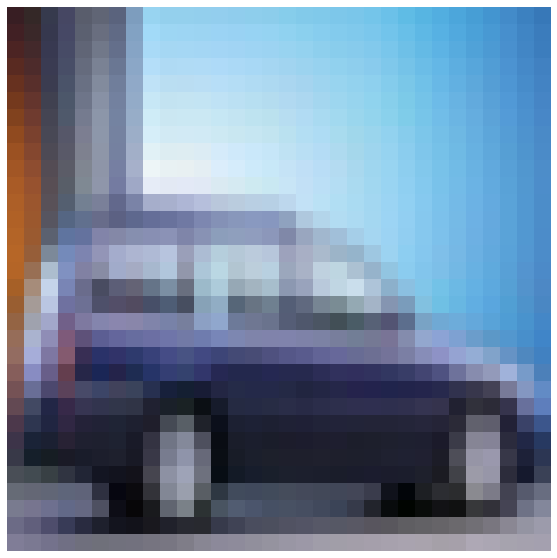

top 5 nearest-neighbor:


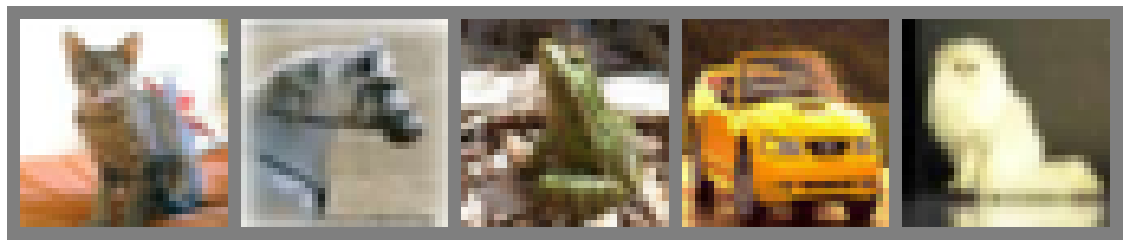

  cat horse  frog   car   cat


In [17]:

print("embedded vector:" )
print(np.round(vectors[0].cpu().detach().numpy(),1))
print(classes[labels[0]])
imshow(images[0])
test=vectors[0]
#dist = []
#for i in range(1,len(vectors)):
#  	similarity = F.cosine_similarity(vectors[i].view(1,-1), test.view(1,-1)).item()
#  	dist.append(similarity)
#dist=torch.tensor(dist)
dist=torch.norm(vectors[1:] - test, dim=1, p=2)
knn = dist.topk(5, largest=False)
knn.indices
print('top 5 nearest-neighbor:')
imshow(make_grid(images[knn.indices]))
print(' '.join('%5s' % classes[labels[j]] for j in knn.indices))

KNN is not proper approach for classification but we can say our vectors are so closed.

## Part 3: Denoising Autoencoder
Finally, I want to implement a denoising autoencoder. The goal is to pass a noisy image to the network and the network has to remove the noise. Therefore, I created an instance of the class NoisyImage and apply it before passing the training images to the network during the training process. Take 5 noisy images from the data. For each image predict a reconstructed image and display both. The target image for the loss calculation is of course the noise-free image!

**Part 3.1** Noisy Image class

In [18]:
class NoisyImage(object):
    # add noise to the input
    def __call__(self,x):
        Noisy=x + torch.ones_like(x).normal_() * 0.3
        return 2*(Noisy-torch.min(Noisy))/(torch.max(Noisy)-torch.min(Noisy))-1   
NNN=NoisyImage()
NoisyTrainset=[]
NoisyTestset=[]
for obj in dataset_train:
    NoisyTrainset.append((NNN(obj[0]),obj[0]))
testset=[]
for obj in dataset_test:
    NoisyTestset.append((NNN(obj[0]),obj[0]))

dataloader_Noisytrain = torch.utils.data.DataLoader(
                 dataset=NoisyTrainset,
                 batch_size=batch_size,
                 shuffle=True)

dataloader_Noisytest = torch.utils.data.DataLoader(
                dataset=NoisyTestset,
                batch_size=batch_size,
                shuffle=False)


orginal result


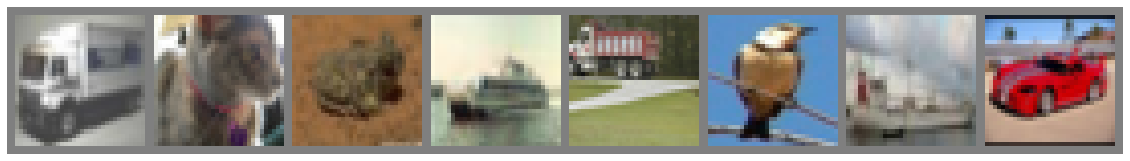

noisy result


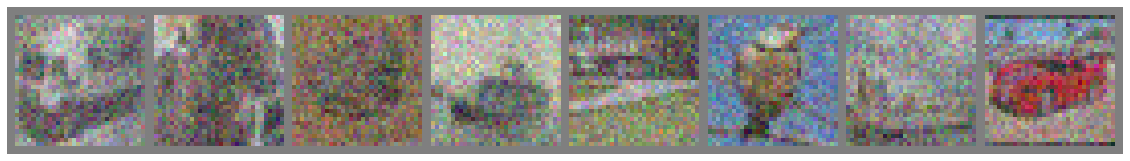

In [19]:
# get some random training images
dataiter = iter(dataloader_train)
images, labels = dataiter.next()
# show images
print('orginal result')
imshow(make_grid(images[:8]))
print('noisy result')
imshow(make_grid(NNN(images[:8])))


**Part 3.2** 
Now train again our net with noisy image as Input and orginal image as target

In [20]:
Denoising =Autoencoder().to(device)
# implement autoencoder training
epochs = 300
# Define an optimizer and criterion
lr = 0.001
opt='adam'
criterion =nn.MSELoss()
if opt=='adam':
    optimizer = optim.Adam(Denoising.parameters(),lr)
elif opt=='sgd':
    optimizer = optim.SGD(Denoising.parameters(),lr,weight_decay=1e-5)

desc = "Train loss: %.4f - Test loss: %.4f"
pbar = trange(epochs, desc=desc % (0., 0.))
history={'train loss':[],'test loss':[]}
# iterate over epochs
for epoch in pbar:
    #training state
    train_loss=0
    Denoising.train() #set Denoising in train state
    for inputs,targets in dataloader_Noisytrain:
        inputs = inputs.to(device) 
        targets=targets.to(device)
        #=====forward=====#
        _, outputs = Denoising(inputs) # forward pass: compute predicted outputs by passing inputs to the Denoising
        #=====calculate loss=====#
        loss = criterion(outputs, targets) # calculate the loss
        train_loss += loss.item()*inputs.size(0) # update running training loss 
        #=====backward=====#
        optimizer.zero_grad() # clear the gradients of all optimized variables
        loss.backward()  # backward pass: compute gradient of the loss with respect to Denoising parameters
        optimizer.step() # perform a single optimization step (parameter update)
    train_loss = train_loss/len(dataloader_train.dataset) # calculate average loss over an epoch
    history['train loss'].append(train_loss)
    
    # testing state after each epoch
    test_loss = 0.0
    Denoising.eval()#set Denoising in validation state
    for inputs,targets in dataloader_Noisytest:
        inputs = inputs.to(device)
        targets=targets.to(device)
        with torch.no_grad():
            _, outputs = Denoising(inputs)
            loss = criterion(outputs, targets) # calculate the loss
            test_loss += loss.item()*inputs.size(0) # update test loss      
    test_loss = test_loss/len(dataloader_test.dataset) # calculate average loss over an epoch
    history['test loss'].append(test_loss)
    
    pbar.set_description(desc % (train_loss,test_loss))
    # I set update to one 
    pbar.update(1)

#save weights  
print('Finished Training')
print('Saving Model...')
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(Denoising.state_dict(), f"./weights/{n_layers}_Denoising_{opt}_{lr}.pkl")
print('Model Saved!')

Train loss: 0.0264 - Test loss: 0.0439: 100%|██████████| 300/300 [02:10<00:00,  2.30it/s]

Finished Training
Saving Model...
Model Saved!


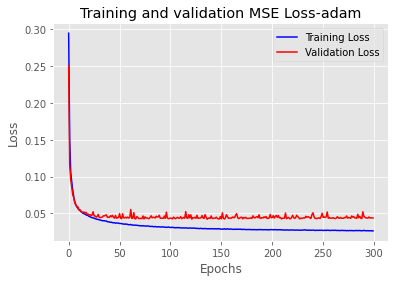

In [21]:
%matplotlib inline
plt.style.use("ggplot")
plt.figure()
plt.plot(history['train loss'], 'b', label='Training Loss')
plt.plot(history['test loss'],'r', label='Validation Loss')
plt.title(f'Training and validation MSE Loss-{opt}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
if not os.path.exists('./Result'):
    os.mkdir('./Result')
plt.savefig(f'Result/Denoising_{n_layers}_MSE_{opt}_lr{lr}.png')
plt.show()

**Part 3.2** check Results

orginal result


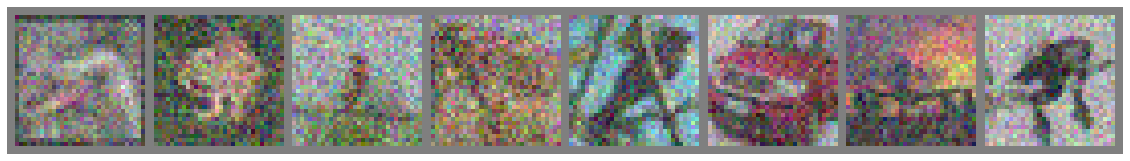

Denoising result


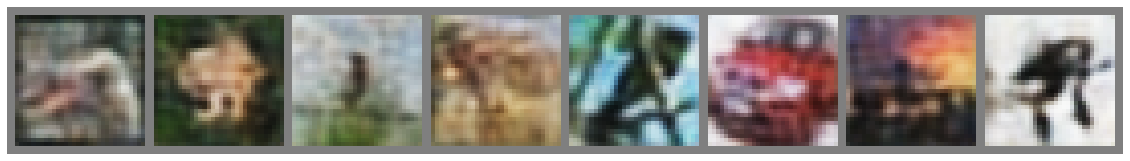

In [22]:
# get some random training images
dataiter = iter(dataloader_Noisytrain)
images, labels = dataiter.next()
# show images
print('orginal result')
imshow(make_grid(images[:8]))
Denoising.eval()
_, outputs = Denoising(images.to(device))
outputs=outputs
print('Denoising result')
torch_imshow(make_grid(outputs[:8]))

We achieve the good result for denoising.

This home work was a good oportunately to learn how to implement convolutional layers and embeding in pythorch.

## Part 4:Refrences
https://github.com/kuangliu/pytorch-cifar

https://pytorch.org/docs/stable/index.html

https://discuss.pytorch.org/t/k-nearest-neighbor-in-pytorch/59695

https://discuss.pytorch.org/t/is-there-a-way-to-calculate-cosine-similarity-between-all-combinations-of-embeddings/19446/5


